In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

In [2]:
data = pd.read_csv("data/train.csv")
data.drop("Id", axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [3]:
missings = pd.DataFrame({"column": data.columns, "missing": data.isnull().sum() / len(data)}).sort_values("missing", ascending=False).reset_index(drop=True)
too_many_missings = missings[missings["missing"] > 0.25]["column"].tolist()

log_features = ["1stFlrSF", "GrLivArea", "LotFrontage"] # based on visually inspecting distributions

categorical = data.select_dtypes(include="object").columns.tolist()

# Target-feature relationship:
target = "SalePrice"
features = data.drop(target, axis=1).columns.tolist()

Prep pipeline:

In [4]:
dropper = FunctionTransformer(func=lambda X: X.drop(too_many_missings, axis=1))

one_hot_encoder = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical)
    ],
    remainder='passthrough'  # Keep other columns (numerical ones) unchanged
)

log_transformer = FunctionTransformer(func=lambda X: X.assign(**{col: np.log1p(X[col]) for col in log_features}))

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('drop', dropper, too_many_missings),  # Dropping features
        ('log', log_transformer, log_features),  # Log transformation
        ('onehot', one_hot_encoder, categorical)  # One-hot encoding
    ],
    remainder='passthrough'  # Leave the rest of the features untouched
)

# Final pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('scaling', MinMaxScaler()),
    ('imputation', IterativeImputer(estimator=BayesianRidge(), random_state=42, verbose=2,  max_iter=100))
])

In [5]:
X = pipeline.fit_transform(data[features])

[IterativeImputer] Completing matrix with shape (1460, 303)
[IterativeImputer] Ending imputation round 1/100, elapsed time 17.99
[IterativeImputer] Change: 0.529453544820477, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 2/100, elapsed time 35.30
[IterativeImputer] Change: 0.008038055827025326, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 3/100, elapsed time 52.06
[IterativeImputer] Change: 3.974911990084484e-05, scaled tolerance: 0.001 
[IterativeImputer] Early stopping criterion reached.


In [6]:
def prep_target(y: np.array, scaler: MinMaxScaler, fit: bool=False) -> np.array:
    logged = np.log1p(y).values.reshape(-1,1)

    if fit:
        return np.array([x.item() for x in scaler.fit_transform(logged)])
    
    return np.array([x.item() for x in scaler.transform(logged)])

target_scaler = MinMaxScaler()
y = prep_target(y=data[target], scaler=target_scaler, fit=True)

Split data:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

## Model

Architecture:

In [86]:
class MLPRegressor(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.a = nn.ReLU()

        self.inlayer = nn.Linear(in_features=X.shape[1], out_features=128)
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.outlayer = nn.Linear(32, 1)

    def forward(self, x):
        out = self.a(self.inlayer(x))
        out = self.a(self.fc1(out))
        out = self.a(self.fc2(out))
        out = self.a(self.fc3(out))
        return self.outlayer(out)

In [87]:
model = MLPRegressor()

Loaders:

In [10]:
X_train = torch.tensor(X_train, dtype=torch.float32).clone().detach()
X_val = torch.tensor(X_val, dtype=torch.float32).clone().detach()
X_test = torch.tensor(X_test, dtype=torch.float32).clone().detach()
y_train = torch.tensor(y_train, dtype=torch.float32).clone().detach()
y_val = torch.tensor(y_val, dtype=torch.float32).clone().detach()
y_test = torch.tensor(y_test, dtype=torch.float32).clone().detach()

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)

Loss fun. and optimizer:

In [88]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, "min", patience=3, factor=0.5)

Early stopping:

In [89]:
class EarlyStopping:
    
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("Inf")
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            

stopper = EarlyStopping(patience=10)

Checkpointing:

In [90]:
def checkpoint(model) -> None:
    torch.save(model.state_dict(), "checkpoint.pth")

def restore_best_weights(model) -> None:
    model.load_state_dict(torch.load("checkpoint.pth"))

### Training

In [91]:
num_epochs = 1000

losses = []

for epoch in range(num_epochs):

    # Train step:

    model.train()
    epoch_train_loss = 0
    for features, target in train_loader:

        output = model(features).squeeze()
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
    
    # Validation step:

    with torch.no_grad():
        epoch_val_loss = 0
        for features, target in val_loader:
            pred = model(features).squeeze()
            loss = criterion(pred, target)
            epoch_val_loss += loss.item()
    
    # Housekeeping:

    stopper(epoch_val_loss)
    scheduler.step(epoch_val_loss)

    print(f"Epoch {epoch+1} done: Training loss: {epoch_train_loss:.4f}, Validation loss: {epoch_val_loss:.4f}, Patience counter: {stopper.counter}")
    losses.append({"epoch": epoch+1, "training": epoch_train_loss, "validation": epoch_val_loss})
        
    if stopper.counter == 0:
        checkpoint(model)
        
    if stopper.early_stop:
        print(f"Patience exceeded, stopping training & restoring best weights...")
        restore_best_weights(model)
        break

Epoch 1 done: Training loss: 3.6698, Validation loss: 0.8510, Patience counter: 0
Epoch 2 done: Training loss: 2.8104, Validation loss: 0.6789, Patience counter: 0
Epoch 3 done: Training loss: 2.1217, Validation loss: 0.4836, Patience counter: 0
Epoch 4 done: Training loss: 1.2084, Validation loss: 0.1682, Patience counter: 0
Epoch 5 done: Training loss: 0.3103, Validation loss: 0.0624, Patience counter: 0
Epoch 6 done: Training loss: 0.2110, Validation loss: 0.0483, Patience counter: 0
Epoch 7 done: Training loss: 0.1548, Validation loss: 0.0401, Patience counter: 0
Epoch 8 done: Training loss: 0.1311, Validation loss: 0.0344, Patience counter: 0
Epoch 9 done: Training loss: 0.1146, Validation loss: 0.0303, Patience counter: 0
Epoch 10 done: Training loss: 0.0998, Validation loss: 0.0264, Patience counter: 0
Epoch 11 done: Training loss: 0.0895, Validation loss: 0.0238, Patience counter: 0
Epoch 12 done: Training loss: 0.0819, Validation loss: 0.0219, Patience counter: 0
Epoch 13 done

/tmp/ipykernel_20860/3484606476.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint.pth"))


Text(0.5, 0.98, 'Training/Validation Loss for Original Model')

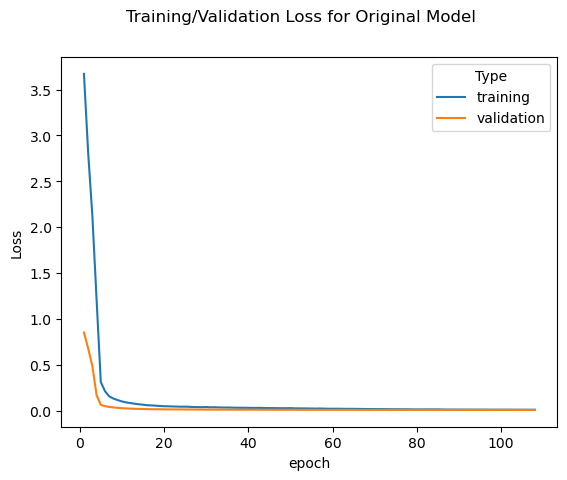

In [92]:
sns.lineplot(x="epoch", y="Loss", hue="Type", data=pd.DataFrame(losses).melt(id_vars="epoch", value_vars=["training", "validation"], var_name="Type", value_name="Loss"))
plt.suptitle("Training/Validation Loss for Original Model")

In [93]:
def collect_preds(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X).squeeze()
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y.cpu().numpy())
            # ^ have to move back to CPU for numpy

    return np.array(predictions), np.array(actuals)

def collect_metrics(predictions, actuals):
    return {
        "MSE": mean_squared_error(actuals, predictions),
        "RMSE": np.sqrt(mean_squared_error(actuals, predictions)),
        "MAE": mean_absolute_error(actuals, predictions),
        "R-squared": r2_score(actuals, predictions)
    }

In [94]:
predictions, actuals = collect_preds(model, test_loader)

In [95]:
collect_metrics(predictions, actuals)

{'MSE': 0.0007555445,
 'RMSE': 0.02748717,
 'MAE': 0.01873825,
 'R-squared': 0.9609278514122277}

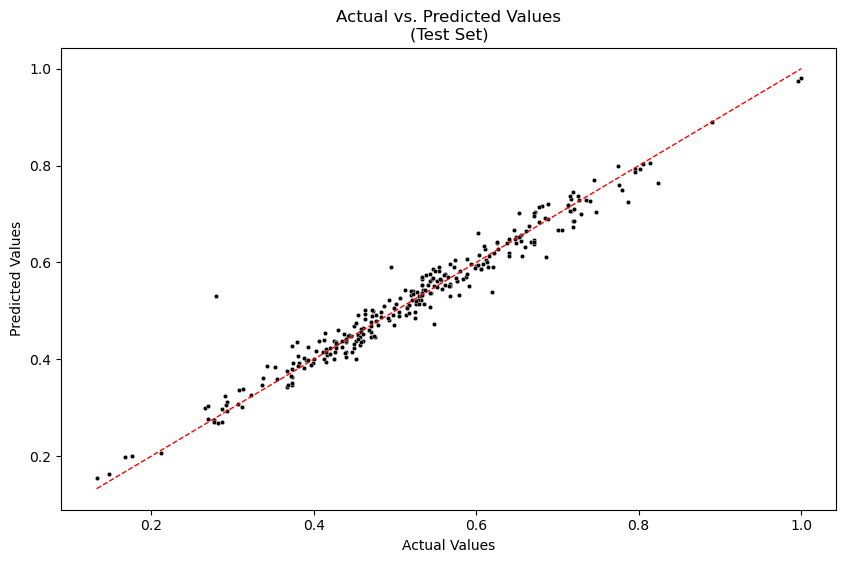

In [96]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actuals, y=predictions, color="black", s=10)
# Main diagonal:
min_val = min(min(actuals), min(predictions))
max_val = max(max(actuals), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values\n(Test Set)')
plt.show()